# Esercitazione 5 - LPC

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import librosa
import scipy.signal as sig
import scipy.signal.windows as windows
from scipy.io.wavfile import write

## Esercizio 1
Creare un programma per poter effettuare analisi e sintesi usando la Linear Prediction. In maniera specifica dovremmo eseguire una analisi frame per frame usando LPC di ordine 24. Dopo aver eseguito analisi dovremmo andare a ricostruire la forma d'onda (a partire dalla rappresentazione alternativa sotto forma di coefficienti LPC), salvando la forma d'onda ed effettuando una analisi MSE delle due forme d'onda. 

In [3]:
def lpc_analysis_synthesis(s, frame_length=480, hop_size=240, lpc_order=12, window_type='hamming'):
    # dobbiamo effettuare una analisi frame dopo frame quindi dobbiamo scegliere la finestra di analisi
    if window_type == 'rectangular':
        window = np.ones(frame_length)
    elif window_type == 'hamming':
        window = windows.hamming(frame_length)
    elif window_type == 'hann':
        window = windows.hann(frame_length)
    else:
        raise ValueError("Unsupported window type. Choose 'rectangular' or 'hamming'.")
    # dal momento che dobbiamo fare una operazione di analisi "a finestra mobile", devo
    # salvarmi un buffer dove vado ad operare
    Buffer = np.zeros(hop_size)
    num_frames =  int(np.floor((len(s)-frame_length)/hop_size)+1)
    synthesized_signal = np.zeros_like(s) # buffer contaning the synthesized signal
    tosave = np.arange(0,hop_size,1)
    # analysis frame-by-frame
    for i in range(num_frames):
        # prima faccio analisi
        start = i * hop_size
        end = min(start + frame_length, len(s))
        frame = np.zeros(frame_length)
        frame[:end-start] = s[start:end]  # Zero-padding if needed
        sigLPC = frame * window
        en = np.sum(sigLPC**2) # short-time energy of the input
        # LPC analysis
        a = librosa.lpc(sigLPC, order=lpc_order)
        # Compute the Gain
        corr = np.correlate(sigLPC, sigLPC, mode='full')
        pos_corr = corr[corr.size // 2:] # positive axes only
        G  = np.sqrt(np.sum(a*pos_corr[:lpc_order+1]))
        # Compute residual (prediction error signal)
        ex = scipy.signal.lfilter(a, [1.0], sigLPC)  # exitation obtained through inverse filtering
        # il segnale ottenuto di eccitazione corrisponde effettivamente all'eccitazione mandata in input, quindi
        # sarebbe il segnale ricostruito
        # faccio analisi e sintesi nello stesso istante
        # Synthesis
        s_recon = scipy.signal.lfilter(G, a, ex)
        ens = np.sum(s_recon**2) # get the short-time energy of the output
        g = np.sqrt(en/ens) # normalizing factor
        s_recon = s_recon*g # energy compensation
        s_recon[:hop_size] = s_recon[:hop_size] + Buffer # overalp and add
        synthesized_signal[tosave] = s_recon[:hop_size] # save the first part of the frame
        Buffer = s_recon[hop_size:frame_length] # buffer the rest of the frame
        tosave = tosave+hop_size

    return synthesized_signal

Per fare analisi del segnale dobbiamo cercare di calcolare i coefficienti LPC per poter avere una rappresentazione alternativa dell'ingresso, che ci permette di anare ad isolare l'eccitazione da quest'ultimo. Infine, dal momento che stiamo facendo sia analisi che sintesi, prendiamo questo ultimo segnale di eccitazione e lo andiamo a ricostruire tramite una serie di operazioni di Overlap-And-Add

In [4]:
# Load the waveform and plot it
filename = 'speechsample.wav'

# data, fs = librosa.load(filename, sr=16000)
#Scipy wav.read reads wav files as 16 bit integers from -32768 to 32767. We need to transform it into floats from -1 to 1.
fs, data = wavfile.read(filename=filename)

if type(data[0]) == np.int16:
    data = np.divide(data,32768,dtype=np.float32)
# 1.2. Make sure the sampling rate is 16kHz. Resample if not 16kHz
if not (fs == 16000):
    data = sig.resample_poly(data,16000,fs)
    fs = 16000

In [5]:
lpc_order = 24
reconstructed_signal = lpc_analysis_synthesis(data, frame_length=480, hop_size=240, lpc_order=lpc_order, window_type='hann')

In [7]:
reconstructed_signal.shape

(64000,)

In [8]:
data.shape

(64000,)

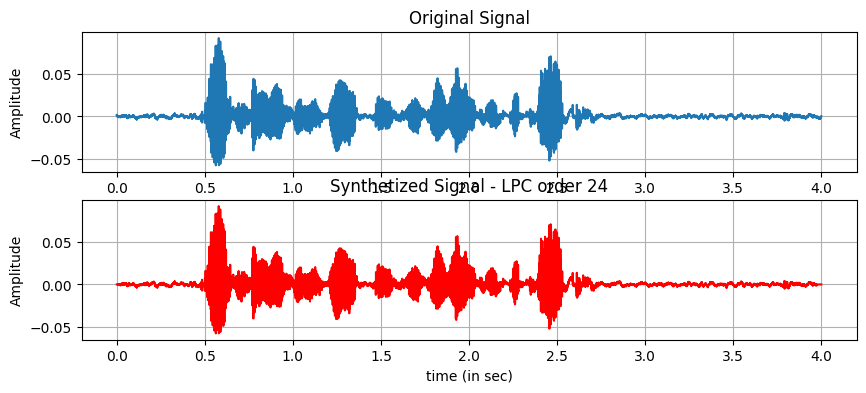

MSE:  2.0260824e-08


In [9]:
# Save as WAV file
out_filename = 'synthesized_speechsample_lpc' + str(lpc_order) + '.wav'
write(out_filename, fs, (reconstructed_signal * 32767).astype(np.int16))
t = np.linspace(0, len(data)/fs, len(data))
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(t, data)
plt.xlabel('time (in sec)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.title('Original Signal')
plt.subplot(2, 1, 2)
plt.plot(t, reconstructed_signal, 'r')
plt.xlabel('time (in sec)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.title('Synthetized Signal - LPC order 24')
plt.show()
mse = np.sum((data-reconstructed_signal)**2,axis=0)/data.shape[0]
print(f'MSE: ', mse)

## Esercizio 2
Effettuare una analisi frame-frame sui frames 0 e 166, comparando la magnitudo della risposta in frequenza della predizione lineare stimata del filtro con la magnitudo del filtro di Fourier. L'obiettivo è quello di applicare la magnitudo di STFT sia al segnale ricostruito che al segnale originale, andando a valutare l'impatto della magnitudo. 

La magnitudo del filtro LP va a filtrare la magnitudo cirocstante della trasformata di Fourier dello speech frame. Quello che ci aspettiamo di dire, che è una smooth line sviluppata da Fourier Transform allo speech frame, conosciuto anche come **envelope**. Due frames da uno speech signal sono considerati, come voiced e unvoiced, cercando di capire cosa accade, plottando la FFT magnitudo con la magnitudo LP.

In [10]:
import matplotlib.pyplot as plt
from scipy.io import wavfile 
import scipy
import numpy as np 
import librosa 
import scipy.signal as sign
import scipy.signal.windows as windows
from scipy.io.wavfile import write
import scipy.fft 
from scipy.signal import freqz 

In [11]:
def lpc_analysis(s, frame_length=480, hop_size=240, lpc_order=12, window_type='hamming'):
    # dobbiamo effettuare una analisi frame dopo frame quindi dobbiamo scegliere la finestra di analisi
    if window_type == 'rectangular':
        window = np.ones(frame_length)
    elif window_type == 'hamming':
        window = windows.hamming(frame_length)
    elif window_type == 'hann':
        window = windows.hann(frame_length)
    else:
        raise ValueError("Unsupported window type. Choose 'rectangular' or 'hamming'.")
    # dal momento che dobbiamo fare una operazione di analisi "a finestra mobile", devo
    # salvarmi un buffer dove vado ad operare
    num_frames =  int(np.floor((len(s)-frame_length)/hop_size)+1)
    NFFT = 2048 # 2048 punti per fare la NFFT
    # analysis frame-by-frame
    fft_lpc = []
    fft_signal = []
    for i in range(num_frames):
        # prima faccio analisi
        start = i * hop_size
        end = min(start + frame_length, len(s))
        frame = np.zeros(frame_length)
        frame[:end-start] = s[start:end]  # Zero-padding if needed
        sigLPC = frame * window
        en = np.sum(sigLPC**2) # short-time energy of the input
        # LPC analysis
        a = librosa.lpc(sigLPC, order=lpc_order)
        # Compute the Gain
        corr = np.correlate(sigLPC, sigLPC, mode='full')
        pos_corr = corr[corr.size // 2:] # positive axes only
        G  = np.sqrt(np.sum(a*pos_corr[:lpc_order+1]))
        # adesso procedo con il calcolo sia dello spettro del segnale dopo aver applicato il filtro, sia del segnale ricostruito
        # questo serve per comparare la magnitudo della risposta in frequenza del filtro lineare LPC e della magnitudo della Trasformata di Fourier
        spectrum = scipy.fft.rfft(sigLPC, n=NFFT)
        # frequency_vector = np.linspace(0, sr/2000, len(spectrum)) 
        logspectrum = 20*np.log10(np.abs(spectrum))
        w, h = freqz(G, a, worN=NFFT) # ricostruisco la risposta con modulo e fase
        fft_lpc.append(logspectrum)
        fft_signal.append((w,h))
    return fft_lpc, fft_signal

In [17]:
def fft_lpc(data, lpc_order, sr=fs):
    fft_lpc, fft_signal = lpc_analysis(data, frame_length=480, hop_size=240, lpc_order=lpc_order, window_type='hann')
    # ma a me interessano solo i frames 166 e 0 da plottare
    spectrum = fft_lpc[166]
    w,h = fft_signal[166]
    frequency_vector = np.linspace(0, sr/2000, len(spectrum)) 
    logspectrum = 20*np.log10(np.abs(spectrum))
    freqs_hz = w*sr/(2*np.pi) 
    plt.plot(frequency_vector, logspectrum, 'r', label='Magnitude of FFT of frame')
    plt.plot(freqs_hz/1000, 20*np.log10(np.abs(h)), 'k', linewidth=3.0, label='Magnitude of LPC filter')
    str1 = 'Voiced Frame in Frequency Domain with orderLPC: '
    str2 = str(lpc_order)
    title = str1 + str2
    plt.title(title)
    plt.xlabel('Frequency (kHz) ')
    plt.ylabel('Magnitude $20\\log_{10}|X_k|$')
    plt.grid(True)
    plt.legend()
    plt.show()
    spectrum = fft_lpc[0]
    w,h = fft_signal[0]
    frequency_vector = np.linspace(0, sr/2000, len(spectrum)) 
    logspectrum = 20*np.log10(np.abs(spectrum))
    freqs_hz = w*sr/(2*np.pi) 
    plt.plot(frequency_vector, logspectrum, 'r', label='Magnitude of FFT of frame')
    plt.plot(freqs_hz/1000, 20*np.log10(np.abs(h)), 'k', linewidth=3.0, label='Magnitude of LPC filter')
    str1 = 'Unvoiced Frame in Frequency Domain with orderLPC: '
    str2 = str(lpc_order)
    title = str1 + str2
    plt.title(title)
    plt.xlabel('Frequency (kHz) ')
    plt.ylabel('Magnitude $20\\log_{10}|X_k|$')
    plt.grid(True)
    plt.legend()
    plt.show()

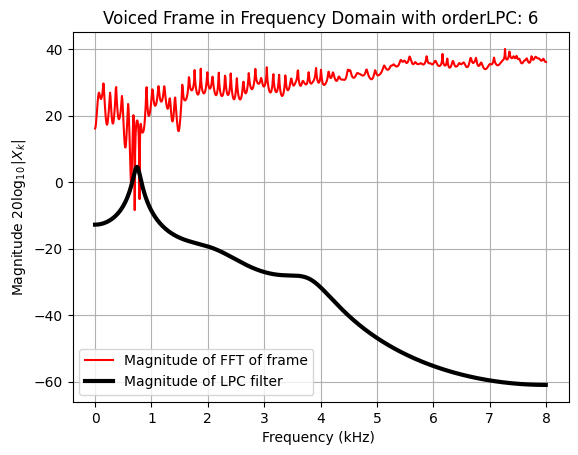

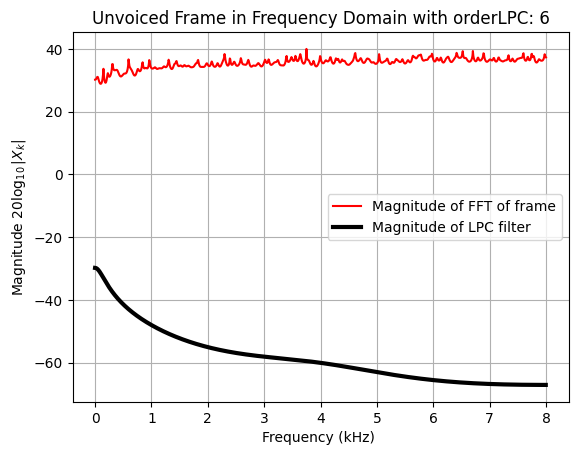

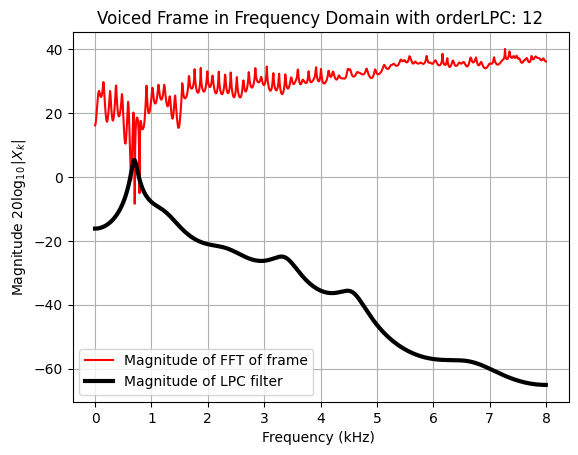

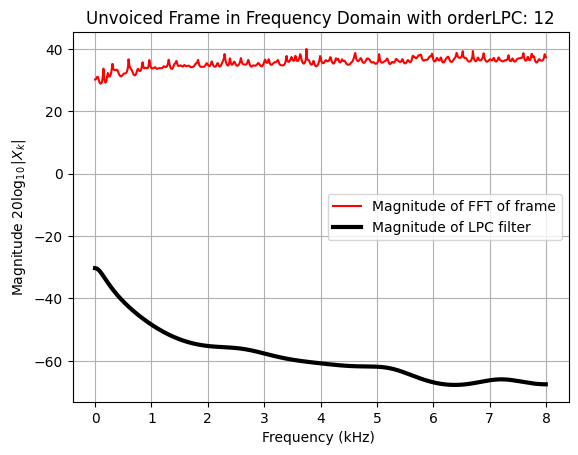

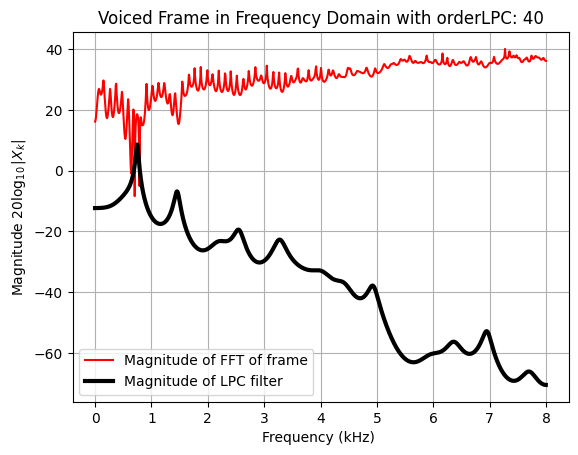

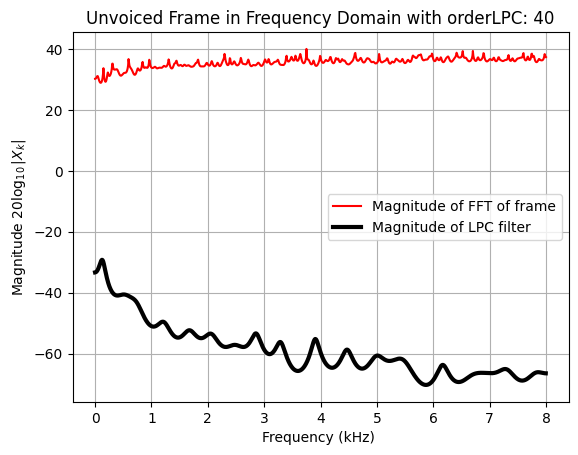

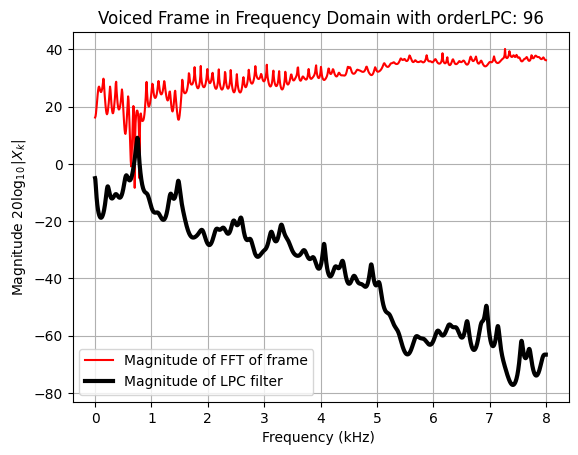

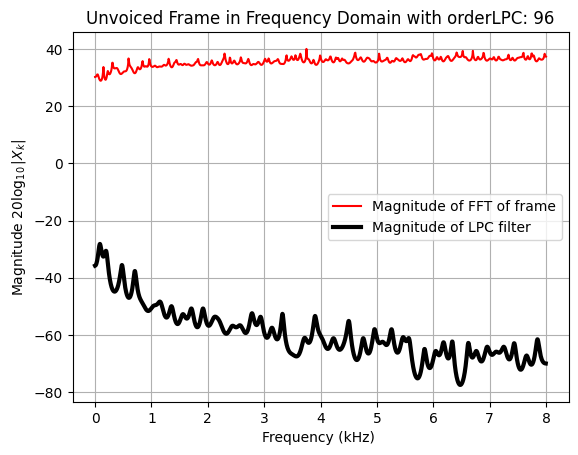

In [18]:
filename = 'speechsample.wav'
data, fs = librosa.load(filename, sr=16000)
lpc_orders = [6, 12, 40, 96]
for lpc_order in lpc_orders:
    reconstructed_signal = fft_lpc(data, lpc_order=lpc_order, sr=fs)

Come possiamo notare, quando l'ordine del filtro è alto allora la magnitudo dello spettro del filtro LP è vicino a matchare quasi tutti i picchi della trasformata di Fourier nello speech frame. Nel frame voiced per esempio le formanti sono inviluppati. Filtri LPC di alto ordine posso effettivamente catturare l'intera magnitudo dello spettro. Tuttavia, questo livello di dettaglio non è ideale e preferiamo avere LPC che envelope e cattura la forma generale della forma d'onda. 

# Esercitazione 3 - Modifica del tratto vocale
Potremmo effettuare delle modifiche nel segnale di eccitazione in uscita dal filtro, andando quindi a creare un segnale whisper, ovvero senza la vibrazione delle corde vocali. Invece di usare la vibrazione del tratto vocale per generare il suono ci basiamo SOLO sul passaggio di aria attraverso l'apertura glottale

Semplicemente dobbiamo aggiungere del semplice rumore al posto del segnale di eccitazione per andare a ricostruire il segnale

In [19]:
def lpc_whispering(s, frame_length=480, hop_size=240, lpc_order=12, window_type='hamming'):
    # dobbiamo effettuare una analisi frame dopo frame quindi dobbiamo scegliere la finestra di analisi
    if window_type == 'rectangular':
        window = np.ones(frame_length)
    elif window_type == 'hamming':
        window = windows.hamming(frame_length)
    elif window_type == 'hann':
        window = windows.hann(frame_length)
    else:
        raise ValueError("Unsupported window type. Choose 'rectangular' or 'hamming'.")
    # dal momento che dobbiamo fare una operazione di analisi "a finestra mobile", devo
    # salvarmi un buffer dove vado ad operare
    Buffer = np.zeros(hop_size)
    num_frames =  int(np.floor((len(s)-frame_length)/hop_size)+1)
    synthesized_signal = np.zeros_like(s) # buffer contaning the synthesized signal
    tosave = np.arange(0,hop_size,1)
    # analysis frame-by-frame
    for i in range(num_frames):
        # prima faccio analisi
        start = i * hop_size
        end = min(start + frame_length, len(s))
        frame = np.zeros(frame_length)
        frame[:end-start] = s[start:end]  # Zero-padding if needed
        sigLPC = frame * window
        en = np.sum(sigLPC**2) # short-time energy of the input
        # LPC analysis
        a = librosa.lpc(sigLPC, order=lpc_order)
        # Compute the Gain
        corr = np.correlate(sigLPC, sigLPC, mode='full')
        pos_corr = corr[corr.size // 2:] # positive axes only
        G  = np.sqrt(np.sum(a*pos_corr[:lpc_order+1]))
        # Compute residual (prediction error signal)
        # ex = scipy.signal.lfilter(a, [1.0], sigLPC)  # exitation obtained through inverse filtering
        ex = np.random.randn(frame_length) # aggiungo rumore gaussiano piuttosto che l'eccitazione dle tratto vocale
        # il segnale ottenuto di eccitazione corrisponde effettivamente all'eccitazione mandata in input, quindi
        # sarebbe il segnale ricostruito
        # faccio analisi e sintesi nello stesso istante
        # Synthesis
        s_recon = scipy.signal.lfilter(G, a, ex)
        ens = np.sum(s_recon**2) # get the short-time energy of the output
        g = np.sqrt(en/ens) # normalizing factor
        s_recon = s_recon*g # energy compensation
        s_recon[:hop_size] = s_recon[:hop_size] + Buffer # overalp and add
        synthesized_signal[tosave] = s_recon[:hop_size] # save the first part of the frame
        Buffer = s_recon[hop_size:frame_length] # buffer the rest of the frame
        tosave = tosave+hop_size

    return synthesized_signal

In [21]:
# Load the waveform and plot it
filename = 'speechsample.wav'

# data, fs = librosa.load(filename, sr=16000)
#Scipy wav.read reads wav files as 16 bit integers from -32768 to 32767. We need to transform it into floats from -1 to 1.
fs, data = wavfile.read(filename=filename)
lpc_order = 24
recon_data = lpc_whispering(s=data, frame_length=480, hop_size=240, lpc_order=lpc_order, window_type='hann')
out_filename = 'whispered_data_lpc_' + str(lpc_order) + '.wav'
norm_audio = (recon_data * 32767).astype(np.int16)
write(out_filename, fs, norm_audio)

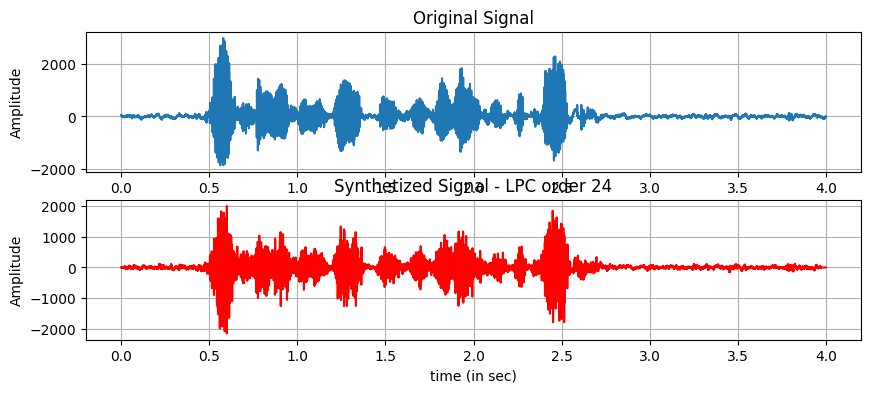

MSE:  2863.05515625


In [22]:
t = np.linspace(0, len(data)/fs, len(data))
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(t, data)
plt.xlabel('time (in sec)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.title('Original Signal')
plt.subplot(2, 1, 2)
plt.plot(t, recon_data, 'r')
plt.xlabel('time (in sec)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.title('Synthetized Signal - LPC order 24')
plt.show()
mse = np.sum((data-recon_data)**2,axis=0)/data.shape[0]
print(f'MSE: ', mse)

# Esercitazione 4 - Modifica delle formanti
adesso dobbiamo selezionare i tre poli più importanti (corrispondenti alle principali tre formanti), modificarle al fine di ottenere una voce più machile o femminile, quindi riadattare il timbro. IN questo caso vogliamo ricostruire un segnale andando a modificare le fomranti

In [33]:
import numpy as np
import scipy.signal
import librosa
import scipy.signal.windows as windows
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

def modify_formants(poles, scale_factor):
    """ Adjust the formant frequencies by modifying the pole magnitudes """
    modified_poles = np.array([
        pole * scale_factor if np.imag(pole) != 0 else pole  # Only modify complex poles
        for pole in poles
    ])
    return modified_poles

def lpc_voice_modification(s, sample_rate=22050, frame_length=480, hop_size=240, lpc_order=12, window_type='hamming', scale_factor=1.0, output_filename="modified_voice.wav"):
    """ Modify vocal tract by scaling prominent formants and save the modified audio """
    
    # Select window function
    if window_type == 'rectangular':
        window = np.ones(frame_length)
    elif window_type == 'hamming':
        window = windows.hamming(frame_length)
    elif window_type == 'hann':
        window = windows.hann(frame_length)
    else:
        raise ValueError("Unsupported window type. Choose 'rectangular', 'hamming', or 'hann'.")
    
    # Buffer initialization
    Buffer = np.zeros(hop_size)
    num_frames = int(np.floor((len(s) - frame_length) / hop_size) + 1)
    synthesized_signal = np.zeros_like(s)
    tosave = np.arange(0, hop_size, 1)

    formant_frequencies_before = []
    formant_frequencies_after = []

    # Frame-by-frame processing
    for i in range(num_frames):
        start = i * hop_size
        end = min(start + frame_length, len(s))
        frame = np.zeros(frame_length)
        frame[:end-start] = s[start:end]  # Zero-padding if needed

        sigLPC = frame * window

        # LPC Analysis
        a = librosa.lpc(sigLPC, order=lpc_order)

        # Get LPC poles
        poles = np.roots(a)
        poles = poles[np.abs(poles) < 1]  # Keep only stable poles

        # Select the top three complex-conjugate pole pairs (six values)
        sorted_poles = sorted(poles, key=lambda p: np.abs(p), reverse=True)
        formant_poles = [p for p in sorted_poles if np.imag(p) != 0][:6]  # Only complex poles
        
        # Convert poles to formant frequencies
        formant_freqs = np.abs(np.angle(formant_poles)) * (sample_rate / np.pi)  # Convert from rad/sample to Hz

        # Modify formants
        modified_poles = modify_formants(formant_poles, scale_factor)

        # Convert back to formant frequencies after modification
        modified_formant_freqs = np.abs(np.angle(modified_poles)) * (sample_rate / np.pi)

        formant_frequencies_before.extend(formant_freqs)
        formant_frequencies_after.extend(modified_formant_freqs)

        # Reconstruct LPC filter with modified poles
        modified_a = np.poly(modified_poles)

        # Generate white Gaussian noise as excitation
        ex = np.random.randn(frame_length)

        # Synthesis
        s_recon = scipy.signal.lfilter([1.0], modified_a, ex)

        # Overlap and add
        s_recon[:hop_size] += Buffer
        synthesized_signal[tosave] = s_recon[:hop_size]
        Buffer = s_recon[hop_size:frame_length]
        tosave += hop_size

    # Normalize output to [-1, 1]
    # synthesized_signal /= np.max(np.abs(synthesized_signal))

    # Save the output as a WAV file
    wav.write(output_filename, sample_rate, np.int16(synthesized_signal * 32767))

    # Plot the formant frequency shifts
    plt.figure(figsize=(10, 5))
    plt.plot(formant_frequencies_before, 'bo-', label="Original Formant Frequencies")
    plt.plot(formant_frequencies_after, 'ro-', label="Modified Formant Frequencies")
    plt.xlabel("Formant Index")
    plt.ylabel("Frequency (Hz)")
    plt.title(f"Formant Frequency Shift (Scale Factor: {scale_factor})")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Modified voice saved as: {output_filename}")
    return synthesized_signal

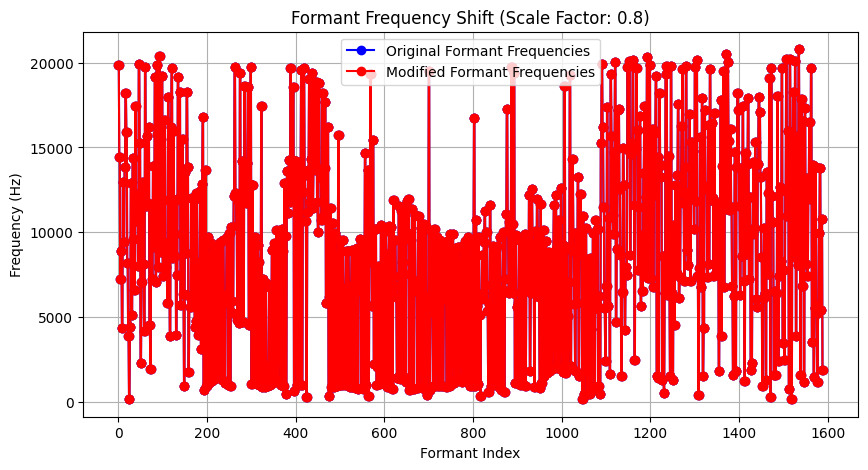

Modified voice saved as: elderly_voice.wav


C:\Users\gabri\AppData\Local\Temp\ipykernel_12188\2628109439.py:81: RuntimeWarning: invalid value encountered in cast
  synthesized_signal[tosave] = s_recon[:hop_size]


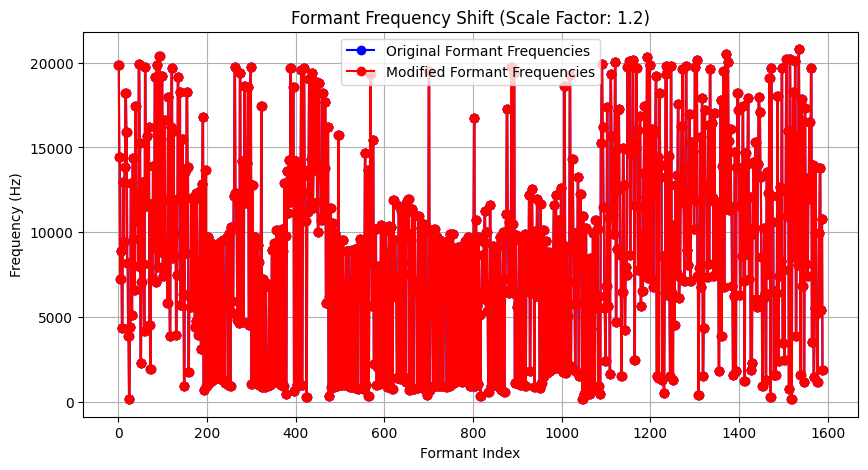

Modified voice saved as: child_voice.wav


In [34]:
# Generate an elderly voice
older_voice = lpc_voice_modification(data, scale_factor=0.8, output_filename="elderly_voice.wav")

# Generate a younger voice
younger_voice = lpc_voice_modification(data, scale_factor=1.2, output_filename="child_voice.wav")